In [30]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd
import numpy as np
import seaborn as sns
from fractions import Fraction as frac

In [31]:
%matplotlib inline

In [32]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("fa21-ds5110-group10-rk") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

In [33]:
spark.sparkContext

<SparkContext master=local[*] appName=fa21-ds5110-group10-rk>

First, let's load our preformatted dataset from dataprep and the prepartitioned divided training and test data.

In [34]:
df = spark.read.parquet("../../../data/processed/chess_games_moves_model.parquet")
trainData = spark.read.parquet("../../../data/processed/training.parquet")
testData = spark.read.parquet("../../../data/processed/testing.parquet")

Next we'll cache the training dataframe as we'll be running cross validation against its data.

In [35]:
trainData.cache()

DataFrame[event: string, white_result: string, first_two: array<string>, ECO: string, EloDiff: int, Opening: string, game_complexity: int]

Next we'll be defining our features vectors by creating a series of data transformations to convert the spark dataframe into a format that is uses for training.

We use the StringIndexer to enumerate our categorical data, and we convert our EloDiff to a magnitude, as NaiveBayes does not function on negative values.

In [36]:
opening_vectorizor = StringIndexer(inputCol="ECO", outputCol="opening_ohe")
gametype_vectorizer = StringIndexer(inputCol="event", outputCol="event_vector")
result_vectorizor = StringIndexer(inputCol="white_result", outputCol="white_result_vector")

# NaiveBayes requires non-negative values; we transpose our ELODiff to ABS Value.
df = df.withColumn('EloDiff', F.abs(F.col('EloDiff')))
trainData = trainData.withColumn('EloDiff', F.abs(F.col('EloDiff')))
testData = testData.withColumn('EloDiff', F.abs(F.col('EloDiff')))

Our opening moves column is still an array of categorical values.
We convert this array into a OneHotEncoding value, so that each distinct value has its own category and indicator variable as part of the featureset.

In [37]:
move_encoder = OneHotEncoder(inputCols=["opening_ohe"],
                             outputCols=["ECO_Type"])

Next we create a vectorizer for our first_two moves, meaning that we capture the first turn in the match and create a distinct indicator for each pair.

In [38]:
firsttwo_vectorizer = CountVectorizer(inputCol="first_two", outputCol="first_two_vectorizer")

As the final prep step, we create a number of feature column collections to use to build our model.
Unlike linear regression, Naive Bayes doesn't have a parametric method to eliminate features, but by running multiple models we can demonstrate the importantce of some variables.

We establish four collections:

1. `full_features` Which covers all our selected features availabile.
2. `moveless_features` Which covers all predictors but your moves.
3. `only_moves_features` Covering only the `first_two` moves.
4. `game_and_skill_features` Covering the chess match type and the magnitude of difference in Elo Score.

In [40]:
models = {
    'full_features': ['ECO_Type', "EloDiff", "event_vector", "first_two_vectorizer"],
    'moveless_features': ["EloDiff", "event_vector"],
    'only_moves_features': ["first_two_vectorizer"],
    'game_and_skill_features': ['ECO_Type', "EloDiff"]
}

features = dict()

for k,v in models.items():
    features[k] = VectorAssembler(inputCols=v, outputCol='features')

Next we build our parameters to be used for our model building.
For Naive Bayes, this means we need to specify the type (multinomial as this is a logistic result).
We will also using a `BinaryClassificationEvaluator` in our crossvalidation model to measure the AUROC to determing what model is best.

We then build a hyperparameter grid based on the Naive Bayes options.
In this case, we have smoothing, which is a 0-1 point value that helps "smooth" irregularities that could come up when producing a result.
We genearate multiple values to run during cross validation to see if this hyperparameter helps our model.

In [41]:
nb = NaiveBayes(modelType="multinomial", featuresCol='features', labelCol='white_result_vector')

In [42]:
auc_evaluator = BinaryClassificationEvaluator(labelCol='white_result_vector', metricName='areaUnderROC')

In [43]:
SEED = 1337

smoothing = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
grid = ParamGridBuilder()\
        .addGrid(nb.smoothing, smoothing)\
        .build()

numFolds = 10

crossval = CrossValidator(
    estimator=nb,
    estimatorParamMaps=grid,
    evaluator=auc_evaluator,
    numFolds=numFolds,
    parallelism=7,
    seed = SEED)

The next set of cells setup our pipeline operations, where there's a series of transformations athat apply to all models, and we add our unique features at the end of the pipeline to help manage the multiple models being built.

In [45]:
all_transforms = [opening_vectorizor,
                  gametype_vectorizer,
                  result_vectorizor,
                  firsttwo_vectorizer,
                  move_encoder]

pipelines = dict()

for k,v in features.items():
    pipelines[k] = Pipeline(stages = all_transforms + [v])

This next frame performs all the computation across each model.
First it fits our model and testing/training dataset based on our earlier defined pipelines,
then it proceeds to perform a crossvalidation training, ultimately identifying the performace of each hyperparameter model across our folds (10).
Next we take the best model from our collection, retrain it using our training data nd then transform our testing data to evaluate its overall performance.

From there we extract the predicted response against the actual result to determine our overall performance.
This is then procesed with a MulticlassMetrics method, which requires transformation from the dataframe API to RDDs to function.
This class provides for us the conflusion matrix showing the TP, FP, TN, FN values, as well as other digonistic measures of interest.

In [53]:
# Create our transforms from our full dataset (considers all cases)

tuning = dict()
best_metrics = dict()
confusionmatrix = dict()

for k,v in pipelines.items():
    print("Modeling {}".format(k))
    
    # Fit to our pipeline, which includes the all_transforms as well as the 'k' model's distinct feature columns.
    feature_model_df = v.fit(df)

    # Transform both training and testing dfs
    training_df = feature_model_df.transform(trainData)
    testing_df = feature_model_df.transform(testData)
    
    
    %time cvmodel = crossval.fit(training_df)
    # Extract the performance of hyperparameters and capture performance.
    tuning_params =  [ list(a.values())[0] for a in cvmodel.getEstimatorParamMaps() ]
    tuning[k] = pd.DataFrame(list(zip(tuning_params, cvmodel.avgMetrics)), columns=['Parameter (smoothing)', 'AUC'])
    # Get the best performing model (per metric)
    nb_best = cvmodel.bestModel
    ml_pipeline = Pipeline(stages=[nb_best])
    
    # Run the train/test model using the best model's pipeline as our guide
    result = ml_pipeline.fit(training_df).transform(testing_df)
    
    # Convert the dataset to an RDD to collect performance measures and confusion matrix
    metrics_rdd = MulticlassMetrics(result.select(['prediction','white_result_vector']).rdd.map(tuple))
    confusionmatrix[k] = pd.DataFrame(metrics_rdd.confusionMatrix().toArray())

    label = 1.0
    best_metrics[k] = pd.DataFrame([['AUROC',     performance[k].loc[performance[k]['AUC'].idxmax()]['AUC']],
                                    ['Accuracy',  metrics_rdd.accuracy],
                                    ['Precision', metrics_rdd.precision(label)],
                                    ['Recall',    metrics_rdd.recall(label)],
                                    ['F1 Score',  metrics_rdd.fMeasure(label)]],
                                  columns=['Predictors', 'Metric', 'Measure'])

Modeling full_features
CPU times: user 4 s, sys: 1.08 s, total: 5.08 s
Wall time: 23min 47s
Modeling moveless_features
CPU times: user 2.65 s, sys: 703 ms, total: 3.35 s
Wall time: 8min 7s
Modeling only_moves_features
CPU times: user 5.32 s, sys: 1.47 s, total: 6.79 s
Wall time: 23min 23s
Modeling game_and_skill_features
CPU times: user 3.16 s, sys: 814 ms, total: 3.97 s
Wall time: 8min 10s


With our training complete and our performance measures captured, let's now compare our models to each other.

First, let's reivew the hyperparameter and crossvalidation metrics.

,predictors,Parameter (smoothing),AUC
0,full_features,0.0,0.5060930062144177
1,full_features,0.2,0.5029916290627848
2,full_features,0.4,0.5026768888753754
3,full_features,0.6,0.5024727198201369
4,full_features,0.8,0.5023166260388257
5,full_features,1.0,0.5021891734965269
6,moveless_features,0.0,0.4966434553272528
7,moveless_features,0.2,0.4966430156903316
8,moveless_features,0.4,0.4966424776469500
9,moveless_features,0.6,0.4966426164031298


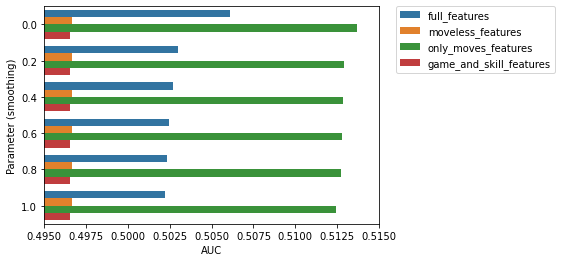

In [101]:
tuning_df = pd.DataFrame(columns=["predictors", "Parameter (smoothing)", "AUC"])
for k,v in tuning.items():
    mydf = v.copy()
    mydf['predictors'] = k
    tuning_df = tuning_df.append(mydf, ignore_index=True)
    
ax3 = sns.barplot(data=tuning_df, x='AUC', y='Parameter (smoothing)', hue='predictors', orient="h")
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax3.set(xlim=(0.495, 0.515))
tuning_df

First we see that cross validation and hyperparameter tuning doesn't have too extreme of an effect, where the full_feature benifits the most from the tuning.

Next let's review the performance measures of each model.

,predictors,Metric,Measure
0,full_features,AUROC,0.5060930062144177
1,full_features,Accuracy,0.5357989900719821
2,full_features,Precision,0.5338984422925050
3,full_features,Recall,0.5167212201406783
4,full_features,F1 Score,0.5251694107716850
5,moveless_features,AUROC,0.4966434553272528
6,moveless_features,Accuracy,0.5310849547020124
7,moveless_features,Precision,0.5293308415568629
8,moveless_features,Recall,0.5064576223971029
9,moveless_features,F1 Score,0.5176416784040587


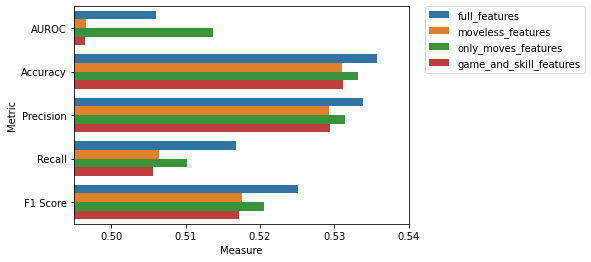

In [103]:
# recompose hierarcical data to dataframe
performance_df = pd.DataFrame(columns=["predictors", 'Metric', 'Measure'])
for k,v in best_metrics.items():
    mydf = v.copy()
    mydf['predictors'] = k
    performance_df = performance_df.append(mydf, ignore_index=True)

# Plot the performances of each metric
ax2 = sns.barplot(data=performance_df, x='Measure', y='Metric', hue='predictors', orient="h")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax2.set(xlim=(0.495, 0.54))
performance_df

Here we see that only the full_features and only_moves_features featuresets are better than guessing (and not by much).
We do see a bit of promise in the full_features collection with the higest accuracy and precision.

Howver, the key insight here is that all models perform relatively the same, where the moves set appears to add about 1% better accountability.

Finally, let's check our confusion matrices to make sure our models appear to have logical measures, as that no category equals zero.

In [104]:
from IPython.display import HTML

for k,v in confusionmatrix.items():
    display(HTML(f"<strong>{k}</strong><br/>"))
    display(v)
    display(HTML("<br/>"))

,0,1
0,322665.0,259097.0
1,277576.0,296784.0


,0,1
0,323110.0,258652.0
1,283471.0,290889.0


,0,1
0,323404.0,258358.0
1,281346.0,293014.0


,0,1
0,323650.0,258112.0
1,283961.0,290399.0
